In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/stores.csv
/kaggle/input/walmart-recruiting-store-sales-forecasting/features.csv.zip
/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip


# Walmart Sales Forecasting

For this notebook, I train a Random Forest Regressor using only the train dataset and information about holidays - no other features included.

In [2]:
# loading used libraries

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
# load both datasets

train = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/train.csv.zip")
test = pd.read_csv("/kaggle/input/walmart-recruiting-store-sales-forecasting/test.csv.zip")

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## Brief analysis of the impact of holidays

From the data I know which observations happened on a holiday. However, what I don't know is how each holiday affect the sales.

The different holidays which we know are the following:

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

To look at this, I aggregate sales on each store per observed date, and plot them together with holidays.

In [5]:
print(f"Train data go from {train.Date.min()} to {train.Date.max()}")

Train data go from 2010-02-05 to 2012-10-26


Note that some holidays are out of the bounds of our train dataset. For plotting sake, I keep only those holidays which happened during the time for which he have observed data.

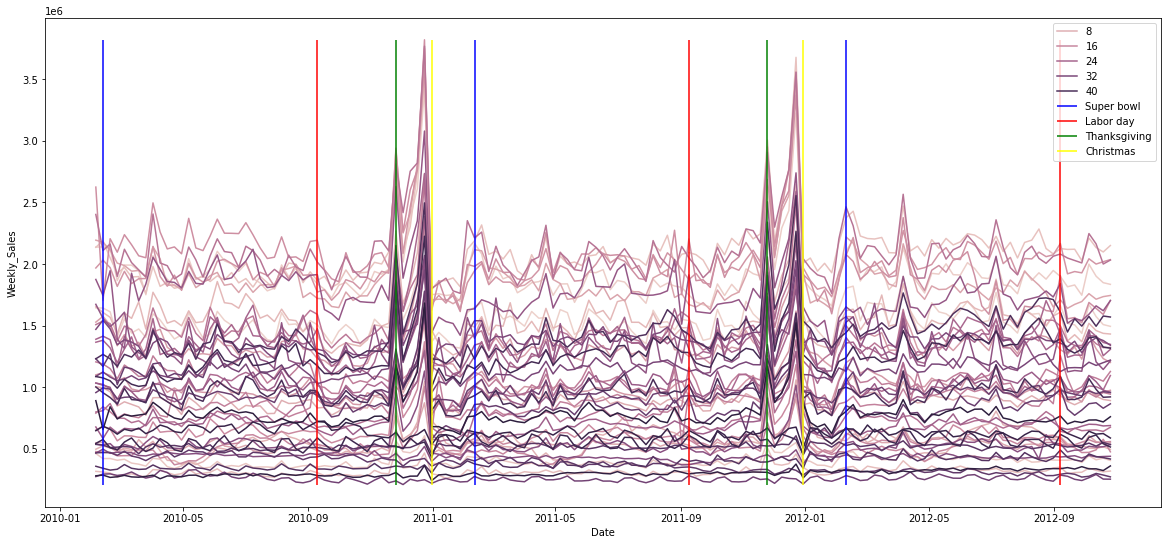

In [6]:
train_plot = train.copy()
train_plot['Date'] = pd.to_datetime(train_plot['Date'])

# prepare sales aggregation by store
train_plot = train_plot.groupby(["Date", "Store"])['Weekly_Sales'].sum().reset_index()

# holiday dates and colos to differentiate them in plot
special_dates = {
    'Super bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Labor day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Thanksgiving': ['2010-11-26', '2011-11-25'],
    'Christmas': ['2010-12-31', '2011-12-30']
}
colors = ['blue', 'red', 'green', 'yellow']

plt.figure(figsize=(20,9))
sns.lineplot(x='Date', y='Weekly_Sales', hue='Store', data=train_plot)

# min and max values for vertical lines
max_val = train_plot.Weekly_Sales.max()
min_val = train_plot.Weekly_Sales.min()

for ix, event in enumerate(special_dates.keys()):
    
    plt.vlines(x      = special_dates[event], 
               colors = colors[ix],
               ymin   = min_val, 
               ymax   = max_val, 
               label  = event)
    
plt.legend()

plt.show()

It's clear from the plot that Thanksgiving and Christmas are the holidays in which sales at Store level rise higher. Super bowl also correlates to some rise in the sales, but not as high as the previous two holidays. As for Labor day, this holiday correlates to high sales in some store, but not all of them.

The conclusion here is that having a representation of which holiday is it that takes place for each observation is relevant to predict the amount of sales. For that, I generate a one-hot-encoding of the holidays and merge it to de train data.

In [7]:
def generate_holidays_dummies(df):

    holidays_dates = {
        'super_bowl': ['2010-02-12', '2011-02-11', '2012-02-10', '2013-02-08'],
        'labor_day': ['2010-09-10', '2011-09-09', '2012-09-07', '2013-09-06'],
        'thanksgiving': ['2010-11-26', '2011-11-25', '2012-11-23', '2013-11-29'],
        'christmas': ['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27']
    }
    # create Series with each holiday and its dates
    holidays_df = pd.DataFrame(holidays_dates).melt().set_index('value')
    
    # merge previous Series to a temporal dataframe
    # observations which aren't holidays will remain NaN
    temp_df = df.merge(holidays_df, how='left', left_on='Date', right_index=True)
    
    # merge one-hot-encoded holidays to dataset
    df = pd.concat([df, pd.get_dummies(temp_df.variable)], axis=1)
    
    return df

Apart from that, the only remaining features available from the data are those related to date.

In [8]:
def process_date(df):
    
    df['Date'] = pd.to_datetime(df.Date)
    df['year'] = df.Date.dt.year
    df['month'] = df.Date.dt.month
    df['week'] = df.Date.dt.week
    df['day'] = df.Date.dt.day
    
    return df

Finally, I define a function to consolidate all of data processing for simplicity.

In [9]:
def process_data(df):
    
    # holidays processing
    df = generate_holidays_dummies(df)
#     df.drop('IsHoliday', axis=1, inplace=True)
    df['IsHoliday'] = df.IsHoliday.map({True: 1, False: 0})
    
    # date processing
    df = process_date(df)
    df.drop('Date', axis=1, inplace=True)
    
    return df

# Model training

In [10]:
train = process_data(train)

features = train.drop('Weekly_Sales', axis=1)
target = train['Weekly_Sales']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [11]:
%%time
model = RandomForestRegressor(n_estimators=300, random_state=24)
model.fit(features, target)

CPU times: user 6min 49s, sys: 6.84 s, total: 6min 56s
Wall time: 6min 56s


RandomForestRegressor(n_estimators=300, random_state=24)

# Prediction

In [12]:
test_processed = process_data(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


Since labor day doesn't occur in test set, we manually add a column for 

In [13]:
test_processed.insert(4, 'labor_day', 0)

In [14]:
preds = model.predict(test_processed)

# Preparing submission

In [15]:
preds_series = pd.Series(preds)

id_col = test.Store.astype(str) + "_" + test.Dept.astype(str) + "_" + test.Date.astype(str)
df_submission = pd.concat([id_col, preds_series], axis=1)
df_submission.columns = ["Id", "Weekly_Sales"]

df_submission.to_csv("submission.csv", index=False)